In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# dropping the location column in the dataframes
def drop_location(dataframe):
    return dataframe.drop(columns=['Location'], inplace=True)

In [4]:
def convert_to_datetime(df):
    df['Current_Date'] = pd.to_datetime(df['Current_Date'])
    return df

## Colombo

In [5]:
colombo_df = pd.read_csv('Cleaned Data/colombo_df.csv')
colombo_df

,HCHO_Reading,Location,Current_Date
0,0.000197,Colombo,2019-01-01
1,0.000263,Colombo,2019-01-02
2,0.000099,Colombo,2019-01-03
3,0.000210,Colombo,2019-01-04
4,0.000179,Colombo,2019-01-05
...,...,...,...
1275,0.000182,Colombo,2023-12-24
1276,0.000343,Colombo,2023-12-25
1277,0.000118,Colombo,2023-12-27
1278,0.000140,Colombo,2023-12-30


In [6]:
drop_location(colombo_df)
convert_to_datetime(colombo_df)
colombo_df

,HCHO_Reading,Current_Date
0,0.000197,2019-01-01
1,0.000263,2019-01-02
2,0.000099,2019-01-03
3,0.000210,2019-01-04
4,0.000179,2019-01-05
...,...,...
1275,0.000182,2023-12-24
1276,0.000343,2023-12-25
1277,0.000118,2023-12-27
1278,0.000140,2023-12-30


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
colombo_df['HCHO_reading_normalized'] = scaler.fit_transform(colombo_df['HCHO_Reading'].values.reshape(-1, 1))

In [8]:
# splitting into training and testing split
train_size = int(len(colombo_df) * 0.8)
test_size = len(colombo_df) - train_size
train, test = colombo_df.iloc[0:train_size], colombo_df.iloc[train_size:len(colombo_df)]

In [9]:
# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

In [10]:
sequence_length = 10
x_train = create_sequences(train['HCHO_reading_normalized'], sequence_length)
x_test = create_sequences(test['HCHO_reading_normalized'], sequence_length)

# reshapinig the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [11]:
# creating the model
colombo_model = Sequential()
colombo_model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
colombo_model.add(Dropout(0.2))
colombo_model.add(LSTM(units=50))
colombo_model.add(Dropout(0.2))
colombo_model.add(Dense(units=1))

print(colombo_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
colombo_model.compile(optimizer='adam', loss='mean_squared_error')

# training the model
colombo_model.fit(x_train, train['HCHO_reading_normalized'][sequence_length:], epochs=100, batch_size=32)

# evaluating the model
loss = colombo_model.evaluate(x_test, test['HCHO_reading_normalized'][sequence_length:])

# predicting the values
colombo_predictions = colombo_model.predict(x_test)

# getting the actual values using inverse transformation
colombo_predictions_actual = scaler.inverse_transform(colombo_predictions)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0792
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0333
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0312
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0310
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0324
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0334
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0327
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0358
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0344
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0334
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0324
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0295
Epoc

In [13]:
colombo_actual_vals = scaler.inverse_transform(test["HCHO_reading_normalized"][sequence_length:].values.reshape(-1, 1))

In [14]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(colombo_actual_vals, colombo_predictions_actual)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(colombo_actual_vals, colombo_predictions_actual)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Colombo MAE is {mae}")
print(f"Colombo MSE is {mse}")
print(f"Colombo RMSE is {rmse}")

Colombo MAE is 6.221284279447629e-05
Colombo MSE is 6.065375686723944e-09
Colombo RMSE is 7.788052186987413e-05


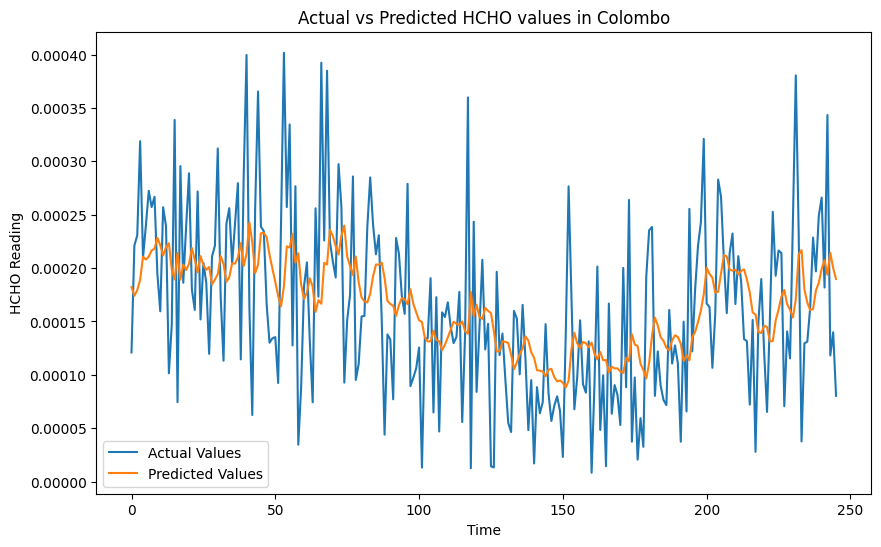

In [15]:
# plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(colombo_actual_vals, label='Actual Values')
plt.plot(colombo_predictions_actual, label='Predicted Values')
plt.title('Actual vs Predicted HCHO values in Colombo')
plt.xlabel("Time")
plt.ylabel("HCHO Reading")
plt.legend()
plt.show()


## Matara

In [16]:
matara_df = pd.read_csv('Cleaned Data/matara_df.csv')
matara_df

,HCHO_Reading,Location,Current_Date
0,0.000006,Matara,2019-01-02
1,0.000236,Matara,2019-01-03
2,0.000064,Matara,2019-01-04
3,0.000053,Matara,2019-01-05
4,0.000132,Matara,2019-01-06
...,...,...,...
847,0.000063,Matara,2023-12-24
848,0.000072,Matara,2023-12-25
849,0.000059,Matara,2023-12-26
850,0.000228,Matara,2023-12-27


In [17]:
drop_location(matara_df)
convert_to_datetime(matara_df)
matara_df

,HCHO_Reading,Current_Date
0,0.000006,2019-01-02
1,0.000236,2019-01-03
2,0.000064,2019-01-04
3,0.000053,2019-01-05
4,0.000132,2019-01-06
...,...,...
847,0.000063,2023-12-24
848,0.000072,2023-12-25
849,0.000059,2023-12-26
850,0.000228,2023-12-27


In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
matara_df['HCHO_reading_normalized'] = scaler.fit_transform(matara_df['HCHO_Reading'].values.reshape(-1, 1))

In [19]:
train_size = int(len(matara_df) * 0.8)
test_size = len(matara_df) - train_size
train, test = matara_df.iloc[0:train_size], matara_df.iloc[train_size:len(matara_df)]

In [20]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

In [21]:
sequence_length = 10
x_train = create_sequences(train['HCHO_reading_normalized'], sequence_length)
x_test = create_sequences(test['HCHO_reading_normalized'], sequence_length)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [22]:
matara_model = Sequential()
matara_model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
matara_model.add(Dropout(0.2))
matara_model.add(LSTM(units=50))
matara_model.add(Dropout(0.2))
matara_model.add(Dense(units=1))

print(matara_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
matara_model.compile(optimizer='adam', loss='mean_squared_error')

matara_model.fit(x_train, train['HCHO_reading_normalized'][sequence_length:], epochs=100, batch_size=32)

loss = matara_model.evaluate(x_test, test['HCHO_reading_normalized'][sequence_length:])

matara_predictions = matara_model.predict(x_test)

matara_predictions_actual = scaler.inverse_transform(matara_predictions)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0706
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0413
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0353
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0354
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0356
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0368
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0342
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0357
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0330
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0330
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0328
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337
Epoc

In [24]:
matara_actual_vals = scaler.inverse_transform(test["HCHO_reading_normalized"][sequence_length:].values.reshape(-1, 1))

In [25]:
mae = mean_absolute_error(matara_actual_vals, matara_predictions_actual)
mse = mean_squared_error(matara_actual_vals, matara_predictions_actual)
rmse = np.sqrt(mse)

print(f"Matara MAE is {mae}")
print(f"Matara MSE is {mse}")
print(f"Matara RMSE is {rmse}")

Matara MAE is 5.635243470960694e-05
Matara MSE is 5.012066266148372e-09
Matara RMSE is 7.079594809131644e-05


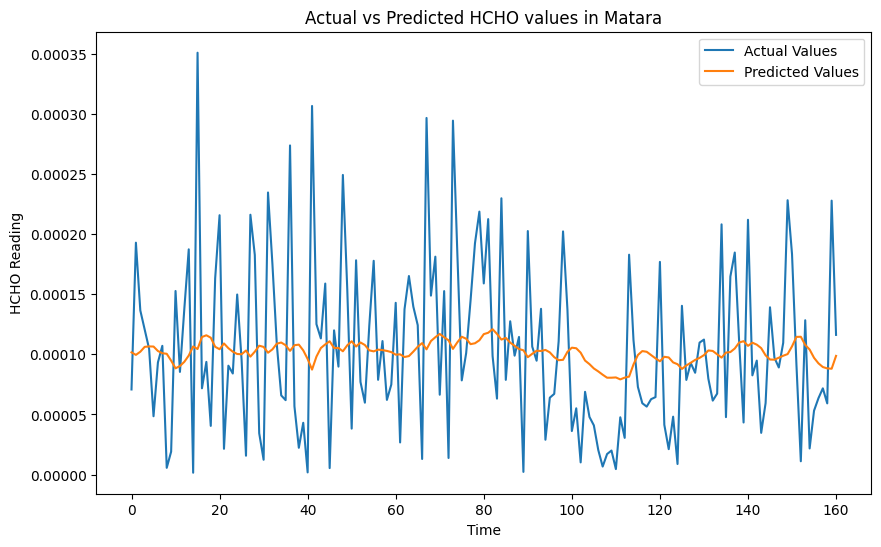

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(matara_actual_vals, label='Actual Values')
plt.plot(matara_predictions_actual, label='Predicted Values')
plt.title('Actual vs Predicted HCHO values in Matara')
plt.xlabel("Time")
plt.ylabel("HCHO Reading")
plt.legend()
plt.show()

## Nuwara Eliya

In [27]:
nuwara_eliya_df = pd.read_csv('Cleaned Data/nuwara_eliya_df.csv')
nuwara_eliya_df

,HCHO_Reading,Location,Current_Date
0,0.000191,Nuwara Eliya,2019-01-03
1,0.000051,Nuwara Eliya,2019-01-04
2,0.000065,Nuwara Eliya,2019-01-05
3,0.000090,Nuwara Eliya,2019-01-06
4,0.000041,Nuwara Eliya,2019-01-07
...,...,...,...
632,0.000041,Nuwara Eliya,2023-11-11
633,0.000036,Nuwara Eliya,2023-11-23
634,0.000108,Nuwara Eliya,2023-12-13
635,0.000006,Nuwara Eliya,2023-12-17


In [28]:
convert_to_datetime(nuwara_eliya_df)
drop_location(nuwara_eliya_df)
nuwara_eliya_df

,HCHO_Reading,Current_Date
0,0.000191,2019-01-03
1,0.000051,2019-01-04
2,0.000065,2019-01-05
3,0.000090,2019-01-06
4,0.000041,2019-01-07
...,...,...
632,0.000041,2023-11-11
633,0.000036,2023-11-23
634,0.000108,2023-12-13
635,0.000006,2023-12-17


In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
nuwara_eliya_df['HCHO_reading_normalized'] = scaler.fit_transform(nuwara_eliya_df['HCHO_Reading'].values.reshape(-1, 1))

In [30]:
train_size = int(len(nuwara_eliya_df) * 0.8)
test_size = len(nuwara_eliya_df) - train_size
train, test = nuwara_eliya_df.iloc[0:train_size], nuwara_eliya_df.iloc[train_size:len(nuwara_eliya_df)]

In [31]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

In [32]:
sequence_length = 10
x_train = create_sequences(train['HCHO_reading_normalized'], sequence_length)
x_test = create_sequences(test['HCHO_reading_normalized'], sequence_length)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [33]:
nuwara_eliya_model = Sequential()
nuwara_eliya_model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
nuwara_eliya_model.add(Dropout(0.2))
nuwara_eliya_model.add(LSTM(units=50))
nuwara_eliya_model.add(Dropout(0.2))
nuwara_eliya_model.add(Dense(units=1))

print(nuwara_eliya_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [34]:
nuwara_eliya_model.compile(optimizer='adam', loss='mean_squared_error')

nuwara_eliya_model.fit(x_train, train['HCHO_reading_normalized'][sequence_length:], epochs=100, batch_size=32)

loss = nuwara_eliya_model.evaluate(x_test, test['HCHO_reading_normalized'][sequence_length:])

nuwara_eliya_predictions = nuwara_eliya_model.predict(x_test)

nuwara_eliya_predictions_actual = scaler.inverse_transform(nuwara_eliya_predictions)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1038
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0526
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0505
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0505
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0485
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0473 
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0484
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0531
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0506 
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0459
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0491
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0473
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0542
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0470
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0470
Ep

In [35]:
nuwara_eliya_actual_vals = scaler.inverse_transform(test["HCHO_reading_normalized"][sequence_length:].values.reshape(-1, 1))

In [36]:
mae = mean_absolute_error(nuwara_eliya_actual_vals, nuwara_eliya_predictions_actual)
mse = mean_squared_error(nuwara_eliya_actual_vals, nuwara_eliya_predictions_actual)
rmse = np.sqrt(mse)

print(f"Nuwara Eliya MAE is {mae}")
print(f"Nuwara Eliya MSE is {mse}")
print(f"Nuwara Eliya RMSE is {rmse}")

Nuwara Eliya MAE is 4.97555624634193e-05
Nuwara Eliya MSE is 3.675082825347889e-09
Nuwara Eliya RMSE is 6.062246139301743e-05


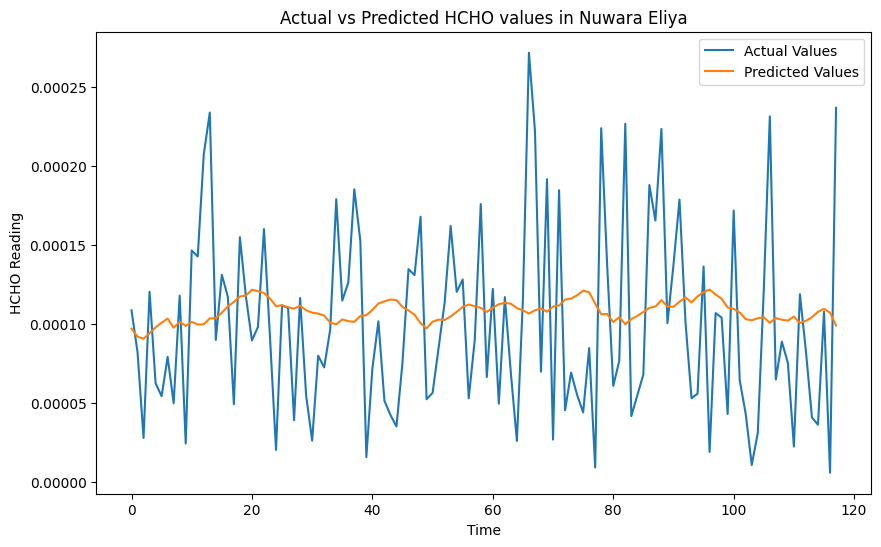

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(nuwara_eliya_actual_vals, label='Actual Values')
plt.plot(nuwara_eliya_predictions_actual, label='Predicted Values')
plt.title('Actual vs Predicted HCHO values in Nuwara Eliya')
plt.xlabel("Time")
plt.ylabel("HCHO Reading")
plt.legend()
plt.show()

## Kandy

In [38]:
kandy_df = pd.read_csv('Cleaned Data/kandy_df.csv')
kandy_df

,HCHO_Reading,Location,Current_Date
0,0.000176,Kandy,2019-01-01
1,0.000092,Kandy,2019-01-02
2,0.000191,Kandy,2019-01-04
3,0.000122,Kandy,2019-01-05
4,0.000163,Kandy,2019-01-07
...,...,...,...
913,0.000116,Kandy,2023-12-07
914,0.000261,Kandy,2023-12-11
915,0.000114,Kandy,2023-12-21
916,0.000116,Kandy,2023-12-23


In [39]:
convert_to_datetime(kandy_df)
drop_location(kandy_df) 
kandy_df

,HCHO_Reading,Current_Date
0,0.000176,2019-01-01
1,0.000092,2019-01-02
2,0.000191,2019-01-04
3,0.000122,2019-01-05
4,0.000163,2019-01-07
...,...,...
913,0.000116,2023-12-07
914,0.000261,2023-12-11
915,0.000114,2023-12-21
916,0.000116,2023-12-23


In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))
kandy_df['HCHO_reading_normalized'] = scaler.fit_transform(kandy_df['HCHO_Reading'].values.reshape(-1, 1))

In [41]:
train_size = int(len(kandy_df) * 0.8)
test_size = len(kandy_df) - train_size
train, test = kandy_df.iloc[0:train_size], kandy_df.iloc[train_size:len(kandy_df)]

In [42]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

In [43]:
sequence_length = 10
x_train = create_sequences(train['HCHO_reading_normalized'], sequence_length)
x_test = create_sequences(test['HCHO_reading_normalized'], sequence_length)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [44]:
kandy_model = Sequential()
kandy_model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
kandy_model.add(Dropout(0.2))
kandy_model.add(LSTM(units=50))
kandy_model.add(Dropout(0.2))
kandy_model.add(Dense(units=1))

print(kandy_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
kandy_model.compile(optimizer='adam', loss='mean_squared_error')

kandy_model.fit(x_train, train['HCHO_reading_normalized'][sequence_length:], epochs=100, batch_size=32)

loss = kandy_model.evaluate(x_test, test['HCHO_reading_normalized'][sequence_length:])

kandy_predictions = kandy_model.predict(x_test)

kandy_predictions_actual = scaler.inverse_transform(kandy_predictions)

Epoch 1/100


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1129
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0427
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0399
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0418
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0432
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0429
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0417
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0410
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0386
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0410
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0417
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0408
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0419
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0423
Epoch 16/100
23/

In [46]:
kandy_actual_vals = scaler.inverse_transform(test["HCHO_reading_normalized"][sequence_length:].values.reshape(-1, 1))

In [47]:
mae = mean_absolute_error(kandy_actual_vals, kandy_predictions_actual)
mse = mean_squared_error(kandy_actual_vals, kandy_predictions_actual)
rmse = np.sqrt(mse)

print(f"Kandy MAE is {mae}")
print(f"Kandy MSE is {mse}")
print(f"Kandy RMSE is {rmse}")

Kandy MAE is 5.0827531702994885e-05
Kandy MSE is 4.14165704962949e-09
Kandy RMSE is 6.435570720324258e-05


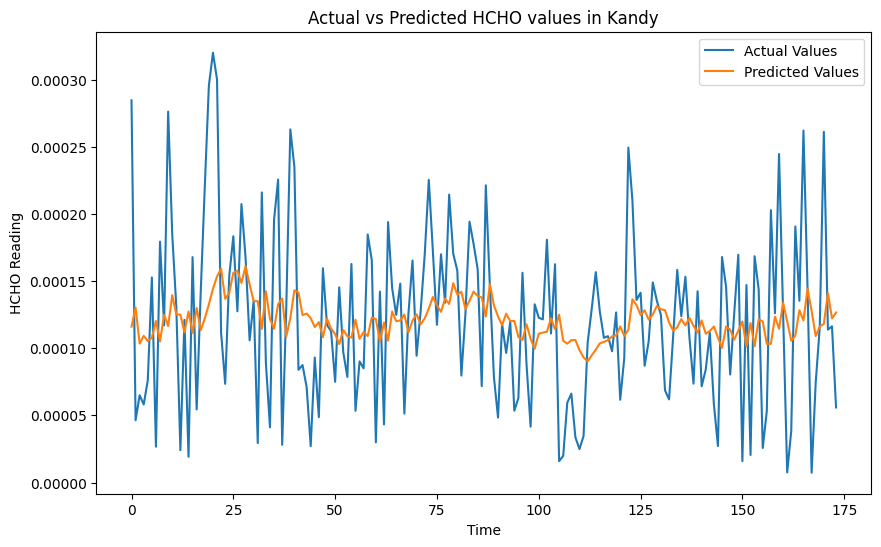

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(kandy_actual_vals, label='Actual Values')
plt.plot(kandy_predictions_actual, label='Predicted Values')
plt.title('Actual vs Predicted HCHO values in Kandy')
plt.xlabel("Time")
plt.ylabel("HCHO Reading")
plt.legend()
plt.show()

## Monaragala

In [49]:
monaragala_df = pd.read_csv('Cleaned Data/monaragala_df.csv')
monaragala_df

,HCHO_Reading,Location,Current_Date
0,0.000019,Monaragala,2019-01-02
1,0.000028,Monaragala,2019-01-03
2,0.000037,Monaragala,2019-01-04
3,0.000146,Monaragala,2019-01-06
4,0.000028,Monaragala,2019-01-07
...,...,...,...
1034,0.000140,Monaragala,2023-12-11
1035,0.000188,Monaragala,2023-12-14
1036,0.000052,Monaragala,2023-12-18
1037,0.000149,Monaragala,2023-12-23


In [50]:
drop_location(monaragala_df)
convert_to_datetime(monaragala_df)
monaragala_df

,HCHO_Reading,Current_Date
0,0.000019,2019-01-02
1,0.000028,2019-01-03
2,0.000037,2019-01-04
3,0.000146,2019-01-06
4,0.000028,2019-01-07
...,...,...
1034,0.000140,2023-12-11
1035,0.000188,2023-12-14
1036,0.000052,2023-12-18
1037,0.000149,2023-12-23


In [51]:
scaler = MinMaxScaler(feature_range=(0, 1))
monaragala_df['HCHO_reading_normalized'] = scaler.fit_transform(monaragala_df['HCHO_Reading'].values.reshape(-1, 1))

In [52]:
train_size = int(len(monaragala_df) * 0.8)  
test_size = len(monaragala_df) - train_size
train, test = monaragala_df.iloc[0:train_size], monaragala_df.iloc[train_size:len(monaragala_df)]

In [53]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

In [54]:
sequence_length = 10
x_train = create_sequences(train['HCHO_reading_normalized'], sequence_length)
x_test = create_sequences(test['HCHO_reading_normalized'], sequence_length)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [55]:
monaragala_model = Sequential()
monaragala_model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
monaragala_model.add(Dropout(0.2))
monaragala_model.add(LSTM(units=50))
monaragala_model.add(Dropout(0.2))
monaragala_model.add(Dense(units=1))

print(monaragala_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [56]:
monaragala_model.compile(optimizer='adam', loss='mean_squared_error')

monaragala_model.fit(x_train, train['HCHO_reading_normalized'][sequence_length:], epochs=100, batch_size=32)

loss = monaragala_model.evaluate(x_test, test['HCHO_reading_normalized'][sequence_length:])

monaragala_predictions = monaragala_model.predict(x_test)

monaragala_predictions_actual = scaler.inverse_transform(monaragala_predictions)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0979
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0396
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0394
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0374
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0347
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0361
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0388
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0370
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0364
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0365
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0363
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0380
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0371
Epoc

In [57]:
monargala_actual_vals = scaler.inverse_transform(test["HCHO_reading_normalized"][sequence_length:].values.reshape(-1, 1))

In [58]:
mae = mean_absolute_error(monargala_actual_vals, monaragala_predictions_actual)
mse = mean_squared_error(monargala_actual_vals, monaragala_predictions_actual)
rmse = np.sqrt(mse)

print(f"Monaragala MAE is {mae}")
print(f"Monaragala MSE is {mse}")
print(f"Monaragala RMSE is {rmse}")

Monaragala MAE is 5.74384162799991e-05
Monaragala MSE is 5.247937444317111e-09
Monaragala RMSE is 7.244264934634232e-05


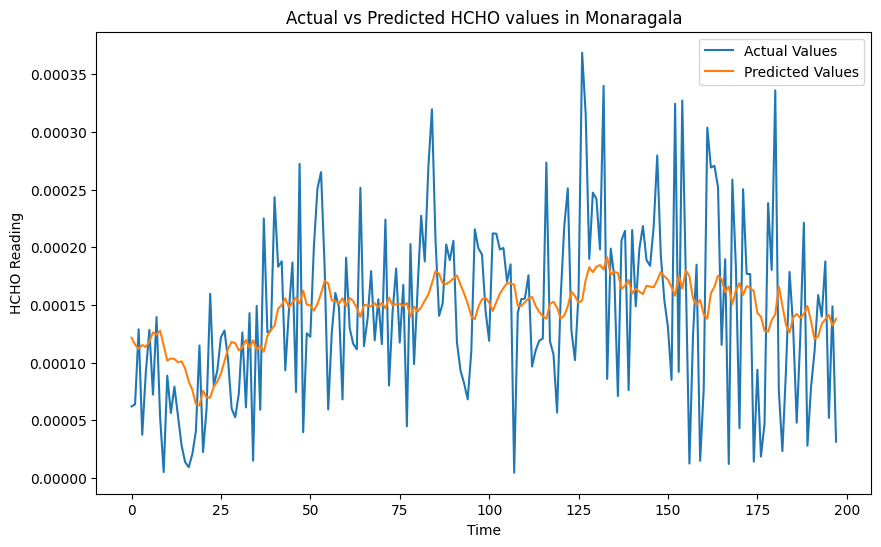

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(monargala_actual_vals, label='Actual Values')
plt.plot(monaragala_predictions_actual, label='Predicted Values')
plt.title('Actual vs Predicted HCHO values in Monaragala')
plt.xlabel("Time")
plt.ylabel("HCHO Reading")
plt.legend()
plt.show()

## Kurunegala